大家好，我是「K同学啊 」！

好像有一段时间没有更新了，这段事情真的太多了，自己也有一点点小偷懒，但是我还在坚持哈，等开学了更新频率可能就会稳定下来。

唠嗑结束，进入正题，前段时间帮别人做了一个3D分类的活，想着怎么也得整理出一篇博客给大家吧，于是乎就有了这篇文章。这篇文章讲解的项目相对早期的项目有如下改进：

- 1.设置的动态学习率
- 2.加入的早停策略
- 3.模型的保存时间更加“智能”
- 4.在数据加载这块也有明显的优化

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1hOjcPYxIvOdg4krDikSwiw （提取码：ysre）

🚀我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2.4.1
- 显卡（GPU）：NVIDIA GeForce RTX 3080

# CT 扫描 3D 图像分类

- 创作时间：2021年8月23日下午
- 任务描述：训练一个 3D 卷积神经网络来预测肺炎的存在。

## 一、前期工作

### 1. 介绍

本案例将展示通过构建 3D 卷积神经网络 (CNN) 来预测计算机断层扫描 (CT) 中病毒性肺炎是否存在。 2D 的 CNN 通常用于处理 RGB 图像（3 个通道）。 3D 的 CNN 仅仅是 3D 等价物，**我们可以将 3D 图像简单理解成 2D 图像的叠加**。3D 的 CNN 可以理解成是学习立体数据的强大模型。

In [1]:
import os,zipfile
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")
    
# 打印显卡信息，确认GPU可用
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2. 加载和预处理数据


数据文件是 Nifti，扩展名为 .nii。我使用`nibabel` 包来读取文件，**你可以通过 `pip install nibabel` 来安装 `nibabel` 包**。

数据预处理步骤：

1. 首先将体积旋转 90 度，确保方向是固定的 
2. 将 HU 值缩放到 0 和 1 之间。
3. 调整宽度、高度和深度。

我定义了几个辅助函数来完成处理数据，这些功能将在构建训练和验证数据集时使用。

In [2]:
import nibabel as nib
from scipy import ndimage

def read_nifti_file(filepath):
    # 读取文件
    scan = nib.load(filepath)
    # 获取数据
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """归一化"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """修改图像大小"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # 旋转
    img = ndimage.rotate(img, 90, reshape=False)
    # 数据调整
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    # 读取文件
    volume = read_nifti_file(path)
    # 归一化
    volume = normalize(volume)
    # 调整尺寸 width, height and depth
    volume = resize_volume(volume)
    return volume

读取CT扫描文件的路径

In [3]:
# “CT-0”文件夹中是正常肺组织的CT扫描
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

# “CT-23”文件夹中是患有肺炎的人的CT扫描
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [4]:
# 读取数据并进行预处理
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# 标签数字化
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

## 二、构建训练和验证集

从类目录中读取扫描并分配标签。对扫描进行下采样以具有 128x128x64 的形状。将原始 HU 值重新调整到 0 到 1 的范围内。最后，将数据集拆分为训练和验证子集。

In [5]:
# 按照7:3的比例划分训练集、验证集
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


## 三、数据增强

CT扫描也通过在训练期间在随机角度旋转来增强数据。由于数据存储在Rank-3的形状（样本，高度，宽度，深度）中，因此我们在轴4处添加大小1的尺寸，以便能够对数据执行3D卷积。因此，新形状（样品，高度，宽度，深度，1）。在那里有不同类型的预处理和增强技术，这个例子显示了一些简单的开始。

In [6]:
import random
from scipy import ndimage

@tf.function
def rotate(volume):
    """不同程度上进行旋转"""
    def scipy_rotate(volume):
        # 定义一些旋转角度
        angles = [-20, -10, -5, 5, 10, 20]
        # 随机选择一个角度
        angle = random.choice(angles)

        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

在定义训练和验证数据加载器的同时，训练数据将进行不同角度的随机旋转。训练和验证数据都已重新调整为具有 0 到 1 之间的值。

In [7]:
# 定义数据加载器
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

## 四、数据可视化

Dimension of the CT scan is: (128, 128, 64, 1)


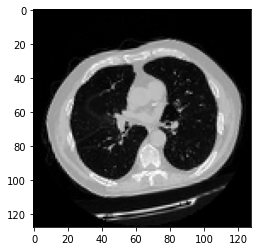

In [8]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

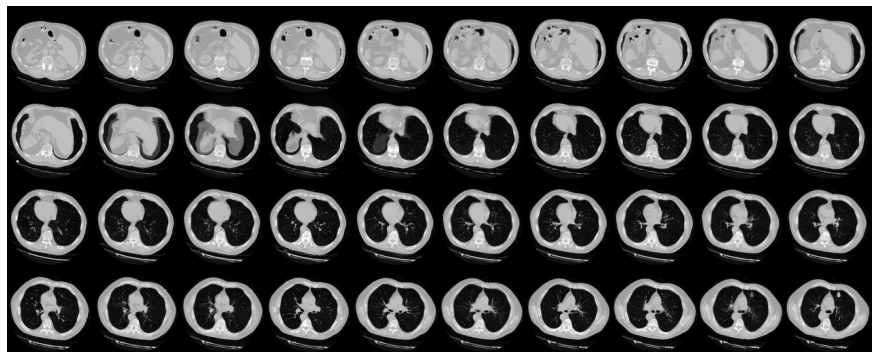

In [9]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## 五、构建3D卷积神经网络模型

为了使模型更容易理解，我将其构建成块。

In [10]:
def get_model(width=128, height=128, depth=64):
    """构建 3D 卷积神经网络模型"""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # 定义模型
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

# 构建模型
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 14, 64)    256   

## 六、训练模型

In [11]:
# 设置动态学习率
initial_learning_rate = 1e-4
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30, decay_rate=0.96, staircase=True
)
# 编译
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)
# 保存模型
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
# 定义早停策略
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
70/70 - 18s - loss: 0.7115 - acc: 0.5143 - val_loss: 0.8686 - val_acc: 0.5000
Epoch 2/100
70/70 - 15s - loss: 0.6595 - acc: 0.6643 - val_loss: 0.8958 - val_acc: 0.5000
Epoch 3/100
70/70 - 15s - loss: 0.6623 - acc: 0.6214 - val_loss: 0.8238 - val_acc: 0.5000
Epoch 4/100
70/70 - 15s - loss: 0.6059 - acc: 0.7000 - val_loss: 2.0436 - val_acc: 0.5000
Epoch 5/100
70/70 - 15s - loss: 0.6278 - acc: 0.6286 - val_loss: 1.8335 - val_acc: 0.5000
Epoch 6/100
70/70 - 15s - loss: 0.6490 - acc: 0.5857 - val_loss: 1.5903 - val_acc: 0.5000
Epoch 7/100
70/70 - 15s - loss: 0.6247 - acc: 0.6571 - val_loss: 1.4214 - val_acc: 0.5000
Epoch 8/100
70/70 - 15s - loss: 0.6174 - acc: 0.6500 - val_loss: 1.3990 - val_acc: 0.5000
Epoch 9/100
70/70 - 15s - loss: 0.6279 - acc: 0.6714 - val_loss: 1.1641 - val_acc: 0.5000
Epoch 10/100
70/70 - 15s - loss: 0.6539 - acc: 0.5929 - val_loss: 0.5836 - val_acc: 0.7000
Epoch 11/100
70/70 - 15s - loss: 0.6382 - acc: 0.6357 - val_loss: 0.5658 - val_acc: 0.6667
Epoch 12

注意：由于样本数量非常少（只有 200 个），而且我没有指定随机种子。因此，你可以预期结果可能会有显着差异。

## 七、可视化模型性能

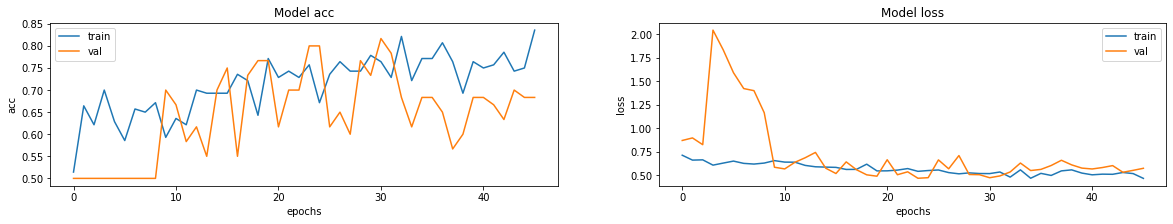

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## 八、对单次 CT 扫描进行预测

In [13]:
# 加载模型
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 27.88 percent confident that CT scan is normal
This model is 72.12 percent confident that CT scan is abnormal


注：本文参考了官方代码，并对里面的一些内容做了改动。

# 同系列作品

🚀 **深度学习新人必看：[《小白入门深度学习》](https://blog.csdn.net/qq_38251616/category_11188161.html)**

1. [小白入门深度学习 | 第一篇：配置深度学习环境](https://mtyjkh.blog.csdn.net/article/details/118575238)
2. [小白入门深度学习 | 第二篇：编译器的使用-Jupyter Notebook](https://mtyjkh.blog.csdn.net/article/details/118814364)
3. [小白入门深度学习 | 第三篇：深度学习初体验](https://mtyjkh.blog.csdn.net/article/details/119081309)

🚀 往期精彩-卷积神经网络篇：

1. [深度学习100例-卷积神经网络（CNN）实现mnist手写数字识别 | 第1天](https://mtyjkh.blog.csdn.net/article/details/116920825) 
2. [深度学习100例-卷积神经网络（CNN）彩色图片分类 | 第2天](https://mtyjkh.blog.csdn.net/article/details/116978213)
3. [深度学习100例-卷积神经网络（CNN）服装图像分类 | 第3天](https://mtyjkh.blog.csdn.net/article/details/116992196)
4. [深度学习100例-卷积神经网络（CNN）花朵识别 | 第4天](https://mtyjkh.blog.csdn.net/article/details/117079919)
5. [深度学习100例-卷积神经网络（CNN）天气识别 | 第5天](https://mtyjkh.blog.csdn.net/article/details/117186183)
6. [深度学习100例-卷积神经网络（VGG-16）识别海贼王草帽一伙 | 第6天](https://mtyjkh.blog.csdn.net/article/details/117331631)
7. [深度学习100例-卷积神经网络（VGG-19）识别灵笼中的人物 | 第7天](https://mtyjkh.blog.csdn.net/article/details/117395797)
8. [深度学习100例-卷积神经网络（ResNet-50）鸟类识别 | 第8天](https://mtyjkh.blog.csdn.net/article/details/117587326)
9. [深度学习100例-卷积神经网络（AlexNet）手把手教学 | 第11天](https://mtyjkh.blog.csdn.net/article/details/117986183)
10. [深度学习100例-卷积神经网络（CNN）识别验证码 | 第12天](https://mtyjkh.blog.csdn.net/article/details/118211253)
11. [深度学习100例-卷积神经网络（Inception V3）识别手语 | 第13天](https://mtyjkh.blog.csdn.net/article/details/118310170)
12. [深度学习100例-卷积神经网络（Inception-ResNet-v2）识别交通标志 | 第14天](https://mtyjkh.blog.csdn.net/article/details/118389790)
13. [深度学习100例-卷积神经网络（CNN）实现车牌识别 | 第15天](https://mtyjkh.blog.csdn.net/article/details/118422302)
14. [深度学习100例-卷积神经网络（CNN）识别神奇宝贝小智一伙 | 第16天](https://mtyjkh.blog.csdn.net/article/details/118631541)
15. [深度学习100例-卷积神经网络（CNN）注意力检测 | 第17天](https://mtyjkh.blog.csdn.net/article/details/118938811)
16. [深度学习100例-卷积神经网络（VGG-16）猫狗识别 | 第21天](https://mtyjkh.blog.csdn.net/article/details/119531838)
17. [深度学习100例-卷积神经网络（LeNet-5）深度学习里的“Hello Word” | 第22天](https://mtyjkh.blog.csdn.net/article/details/119700804)

🚀 往期精彩-循环神经网络篇：

1. [深度学习100例-循环神经网络（RNN）实现股票预测 | 第9天](https://mtyjkh.blog.csdn.net/article/details/117752046)
2. [深度学习100例-循环神经网络（LSTM）实现股票预测 | 第10天](https://mtyjkh.blog.csdn.net/article/details/117907074)

🚀 往期精彩-生成对抗网络篇：

1. [深度学习100例-生成对抗网络（GAN）手写数字生成 | 第18天](https://mtyjkh.blog.csdn.net/article/details/118995896)
2. [深度学习100例-生成对抗网络（DCGAN）手写数字生成 | 第19天](https://mtyjkh.blog.csdn.net/article/details/119133575)
3. [深度学习100例-生成对抗网络（DCGAN）生成动漫小姐姐 | 第20天](https://mtyjkh.blog.csdn.net/article/details/119182578)


**🚀 本文选自专栏：[《深度学习100例》](https://blog.csdn.net/qq_38251616/category_11068756.html)**

**💖先赞后看，再收藏，养成好习惯！💖**